<font size="+3"><strong>Project: Earthquake Damage in Kavrepalanchok 🇳🇵</strong></font>

In this project we will build a classification model to predict building damage for the district of [Kavrepalanchok](https://en.wikipedia.org/wiki/Kavrepalanchok_District).

In [46]:
# Import libraries here
import sqlite3
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder, OrdinalEncoder
from IPython.display import VimeoVideo
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted
import warnings


warnings.simplefilter(action="ignore", category=FutureWarning)

# Prepare Data

## Connect

Connect to the `nepal.sqlite` database.

In [3]:
%load_ext sql
%sql sqlite:////home/jovyan/nepal.sqlite

'Connected: @/home/jovyan/nepal.sqlite'

What districts are represented in the `id_map` table? Determine the unique values in the **`district_id`** column.

In [4]:
%%sql
SELECT distinct(district_id) FROM id_map

 * sqlite:////home/jovyan/nepal.sqlite
Done.


district_id
1
2
3
4


What's the district ID for Kavrepalanchok? In some other explorations, we already know that Gorkha is `4` and Ramechhap is `2`. Of the remaining districts, Kavrepalanchok is the one with the largest number of observations in the `id_map` table.

Calculate the number of observations in the `id_map` table associated with district `1`.

In [8]:
%%sql
SELECT count(*)
FROM id_map
WHERE district_id = 1

 * sqlite:////home/jovyan/nepal.sqlite
Done.


count(*)
36112


Calculate the number of observations in the `id_map` table associated with district `3`.

In [13]:
%%sql
SELECT count(*)
FROM id_map
WHERE district_id = 3

 * sqlite:////home/jovyan/nepal.sqlite
Done.


count(*)
82684


Join the unique building IDs from Kavrepalanchok in `id_map`, all the columns from  `building_structure`, and the **`damage_grade`** column from `building_damage`, limiting. Make sure you rename the **`building_id`** column in `id_map` as **`b_id`** and limit your results to the first five rows of the new table.

In [15]:
%%sql
SELECT distinct(i.building_id) as b_id,
    s.*,
    d.damage_grade
FROM id_map as i
JOIN building_structure as s ON i.building_id = s.building_id
JOIN building_damage as d ON d.building_id = i.building_id
WHERE district_id = 3
LIMIT 5

 * sqlite:////home/jovyan/nepal.sqlite
Done.


b_id,building_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,condition_post_eq,superstructure,damage_grade
87473,87473,2,1,15,382,18,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,"Stone, mud mortar",Grade 4
87479,87479,1,0,12,328,7,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,Damaged-Rubble clear,"Stone, mud mortar",Grade 5
87482,87482,2,1,23,427,20,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Not used,"Stone, mud mortar",Grade 4
87491,87491,2,1,12,427,14,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Not used,"Stone, mud mortar",Grade 4
87496,87496,2,0,32,360,18,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Rubble clear,"Stone, mud mortar",Grade 5


## Import

Let's write a `wrangle` function that will use the query you created in the previous task to create a DataFrame. In addition your function should:

1. Create a `"severe_damage"` column, where all buildings with a damage grade greater than `3` should be encoded as `1`. All other buildings should be encoded at `0`. 
2. Drop any columns that could cause issues with leakage or multicollinearity in your model.

In [20]:
# Build your `wrangle` function here
def wrangle(db_path):
    
    # Connect to database
    conn = sqlite3.connect(db_path)

    # Construct query
    query = """
        SELECT distinct(i.building_id) AS b_id,
           s.*,
           d.damage_grade
        FROM id_map AS i
        JOIN building_structure AS s ON i.building_id = s.building_id
        JOIN building_damage AS d ON i.building_id = d.building_id
        WHERE district_id = 3
    """
    
    # Read query results into DataFrame
    df = pd.read_sql(query, conn, index_col = "b_id")
    
    #Create binary target
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)
    
    
    #Identify leaky columns
    drop_cols = [col for col in df.columns if "post_eq" in col]
    
    #drop damage grade too
    drop_cols.append("damage_grade")
    
    #Drop colinearity column
    drop_cols.append("count_floors_pre_eq")
    
    #Drop High Cardinality categorical column
    drop_cols.append("building_id")
    
    #Drop leaky columns
    df.drop(columns = drop_cols, inplace = True)
    
    
    return df


Use your `wrangle` function to query the database at `"/home/jovyan/nepal.sqlite"` and return  your cleaned results.

In [21]:
df = wrangle("/home/jovyan/nepal.sqlite")
df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,
87473,15,382,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87479,12,328,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,"Stone, mud mortar",1
87482,23,427,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87491,12,427,14,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87496,32,360,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1


## Explore

Are the classes in this dataset balanced? Create a bar chart with the normalized value counts from the `"severe_damage"` column. Be sure to label the x-axis `"Severe Damage"` and the y-axis `"Relative Frequency"`. Use the title `"Kavrepalanchok, Class Balance"`.

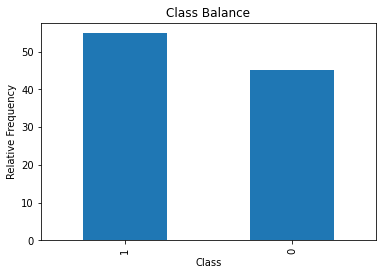

In [23]:
# Plot value counts of `"severe_damage"`
(df["severe_damage"].value_counts(normalize = True) * 100).plot(
    kind = 'bar', xlabel = "Class", ylabel = "Relative Frequency", 
    title = "Class Balance"
)

Is there a relationship between the footprint size of a building and the damage it sustained in the earthquake? Use seaborn to create a boxplot that shows the distributions of the `"plinth_area_sq_ft"` column for both groups in the `"severe_damage"` column. Label your x-axis `"Severe Damage"` and y-axis `"Plinth Area [sq. ft.]"`. Use the title `"Kavrepalanchok, Plinth Area vs Building Damage"`. 

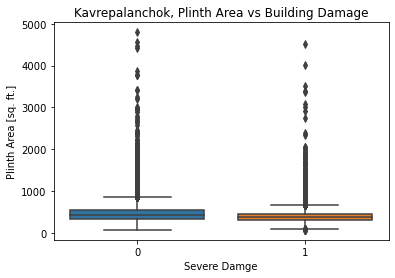

In [25]:
sns.boxplot(x = "severe_damage", y = "plinth_area_sq_ft", data = df)
# Label axes
plt.xlabel("Severe Damge")
plt.ylabel("Plinth Area [sq. ft.]")
plt.title("Kavrepalanchok, Plinth Area vs Building Damage");

Are buildings with certain roof types more likely to suffer severe damage? Create a pivot table of `df` where the index is `"roof_type"` and the values come from the `"severe_damage"` column, aggregated by the mean.

In [28]:
roof_pivot = pd.pivot_table(
    df, index = "roof_type", values = "severe_damage", aggfunc = np.mean
).sort_values(by = "severe_damage")
roof_pivot

,severe_damage
roof_type,
RCC/RB/RBC,0.040715
Bamboo/Timber-Heavy roof,0.569477
Bamboo/Timber-Light roof,0.604842


## Split

Create your feature matrix `X` and target vector `y`. Your target is `"severe_damage"`. 

In [30]:
target = "severe_damage"
X = df.drop(columns = [target])
y = df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (76533, 11)
y shape: (76533,)


Divide your dataset into training and validation sets using a randomized split. Your validation set should be 20% of your data.

In [33]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size = 0.2, random_state = 42
)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (61226, 11)
y_train shape: (61226,)
X_val shape: (15307, 11)
y_val shape: (15307,)


# Build Model

## Baseline

Calculate the baseline accuracy score for your model.

In [35]:
acc_baseline = y_train.value_counts(normalize = True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.55


## Iterate

Create a model `model_lr` that uses logistic regression to predict building damage. Be sure to include an appropriate encoder for categorical features. 

In [37]:
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names = True), 
    LogisticRegression(max_iter = 10000)
)
# Fit model to training data
model_lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration',
                                     'superstructure'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=10000))])

Calculate training and validation accuracy score for `model_lr`. 

In [40]:
lr_train_acc = accuracy_score(y_train, model_lr.predict(X_train))
lr_val_acc = model_lr.score(X_val, y_val)

print("Logistic Regression, Training Accuracy Score:", lr_train_acc)
print("Logistic Regression, Validation Accuracy Score:", lr_val_acc)

Logistic Regression, Training Accuracy Score: 0.6515042628948486
Logistic Regression, Validation Accuracy Score: 0.6536878552296335


Perhaps a decision tree model will perform better than logistic regression, but what's the best hyperparameter value for `max_depth`? Create a `for` loop to train and evaluate the model `model_dt` at all depths from 1 to 15. Be sure to use an appropriate encoder for your model, and to record its training and validation accuracy scores at every depth. The grader will evaluate your validation accuracy scores only.

In [48]:
depth_hyperparams = range(1, 16)
training_acc = []
validation_acc = []
for d in depth_hyperparams:
    model_dt = make_pipeline(
        OrdinalEncoder(), 
        DecisionTreeClassifier(max_depth = d, random_state = 42)
    )
    model_dt.fit(X_train, y_train)
    # Fit model to training data
    model_dt.fit(X_train, y_train)
    # Calculate training accuracy score and append to `training_acc`
    training_acc.append(model_dt.score(X_train, y_train))
    # Calculate validation accuracy score and append to `training_acc`
    validation_acc.append(model_dt.score(X_val, y_val))

print("Training Accuracy Scores:", training_acc[:3])
print("Validation Accuracy Scores:", validation_acc[:3])
    

Training Accuracy Scores: [0.6303041191650606, 0.6303041191650606, 0.642292490118577]
Validation Accuracy Scores: [0.6350035931273273, 0.6350035931273273, 0.6453909975828053]


In [58]:
validation_acc.index(0.6653818514405174)

9

Using the values in `training_acc` and `validation_acc`, plot the validation curve for `model_dt`. Label your x-axis `"Max Depth"` and your y-axis `"Accuracy Score"`. Use the title `"Validation Curve, Decision Tree Model"`, and include a legend. 

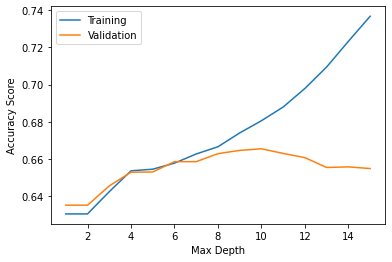

In [50]:
plt.plot(depth_hyperparams, training_acc, label = "Training")
plt.plot(depth_hyperparams, validation_acc, label = "Validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.legend();

Build and train a new decision tree model `final_model_dt`, using the value for `max_depth` that yielded the best validation accuracy score in your plot above. 

In [62]:
#best_p = validation_acc[validation_acc == validation_acc.min()].index[0]
final_model_dt = make_pipeline(
        OrdinalEncoder(), 
        DecisionTreeClassifier(max_depth = 10, random_state = 42)
    )
final_model_dt.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'superstructure'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Moderate slope    2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'dat...
Building with Central Courtyard     9
H-shape                            10
NaN                                -2
dtype: int64},
                                         {'col': 'superstructure',
                   

## Evaluate

How does your model perform on the test set? First, read the CSV file `"data/kavrepalanchok-test-features.csv"` into the DataFrame `X_test`. Next, use `final_model_dt` to generate a list of test predictions `y_test_pred`. Finally, submit your test predictions to the grader to see how your model performs.

In [ ]:
X_test = pd.read_csv("data/kavrepalanchok-test-features.csv", index_col="b_id")
y_test_pred = ...
y_test_pred[:5]

# Communicate Results

What are the most important features for `final_model_dt`? Create a Series Gini `feat_imp`, where the index labels are the feature names for your dataset and the values are the feature importances for your model. Be sure that the Series is sorted from smallest to largest feature importance. 

In [ ]:

feat_imp = ...
feat_imp.head()

Create a horizontal bar chart of `feat_imp`. Label your x-axis `"Gini Importance"` and your y-axis `"Label"`. Use the title `"Kavrepalanchok Decision Tree, Feature Importance"`.

Any relationship between this plot and the exploratory data analysis we did regarding roof type?